# Обработка текстов в машинном обучении на примере задачи сантимент анализа

# Задача 
<font color=darkblue> Построить модель которая по произвольному тексту будет предстазывать  этот текст имеет негативный или позитивный контекст. 

### 1. Загрузка данных 
<font color=darkblue> Для построения модели будем использовать выборку, подготовленную "Лабораторией интернет-исследований НИУ ВШЭ – СПб" и доступную по адресу http://linis-crowd.org/</font> 
<font color=darkblue> Она на русском языке, бесплатна  и доступна для скачивания. Мы специально сократили объем данных для ускорения обучения, сама выборка содержит большой объем данных, правда некоторые оценки положительного/отрицательного контента субъективны.

In [21]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib 
warnings.filterwarnings('ignore')

df = pd.read_csv(u'../data/reviewnorm_10k.csv', encoding='utf-8')
df.head()

,Text,Sentiment,NormText
0,"прямо там, где и живут, чуть ли не себе под но...",-1.0,прямо жить чуть не_себя нога безобразие кстати...
1,из комментариев к тому же Вучику: Порядка 85% ...,-1.0,комментарий вучик порядок пассажирский транспо...
2,"кому-то надо, видимо уродам всяким. почему а ...",-1.0,урод всякий знаете олег дело дом жить скоко эт...
3,"не стал исходить из постулата, что чиновник эт...",-1.0,не_стать исходить постулат чиновник всегда зло...
4,вы не нужны - она вас отторгает. Русских нет ...,-1.0,не_нужный отторгать русский нет москвабад раб ...


### Предпроцессинг данных 

<font color=darkblue>Колонка NormText была создана обработкой текста, включающей в себя:<br/>
    
 - удаление общейпотребительных стоп слов(слова не влияющие на содержание), подписей,URL, пунктуации; <br/>
 - присоединение частицы НЕ к слову; <br/>
 - токенизация и нормализация используя пакет pymorphy2.<br/>

Исходный код процедур вы можете посмотреть в файле text.py (приложения к материалам курса)</font>

### Процедуры для очистки текста
<font color=darkblue>список стоп-слов (доступен в материалах курса). <br/>

Удаление стоп слов можно не выполнять, во многих случаях слова "ну" "тоже" выполняют важную роль для задачи негативного и позитивного содержания.</font>

In [22]:
from text import Text, StopWords
stop_words_file = "Stop-words.txt"
stop_words = StopWords(stop_words_file)
stop_words.stop_words[:10]

[добрый утро,
 с уважение,
 добрый день,
 добрый вечер,
 какой-либо,
 кто,
 о,
 то,
 отчего-то,
 тогда-то]

In [23]:
def clean_text_with_norm(text, stop_words):    
    text = Text(text)
    text.delete_signature()
    text.delete_url()
    text.add_whitespace()
    text.tokenize()
    text.normalize()
    text.not_particle()
    text.delete_stop_words(stop_words)
    
    return str(text)

### Проведем демонстрацию работы процедур
<font color=darkblue>для этого возьмем первую строку текста, так выглядит исходный текст 

In [24]:
print(df.Text[0],df.Sentiment[0])

прямо там, где и живут, чуть ли не себе под ноги Безобразие какое! Кстати я урн не увидел тоже( Фу как грязно! Как некрасиво!Меня поразило, когда ехали из России в прошлые выходные - мусорные мешки вдоль дороги. Ну это вообще. Где-то собирают на дачах или еще где, а по дороге - в окно. И валяются эти мешки разодранные вдоль дороги. Ужасно! Свинство ужасное( Очень наглядно проиллюстрировали проблему!Сейчас много таких несанкционированных свалок, очень обидно, что наш народ так неуважительно относится к окружающему миру и к самим себе! Может, как отметили выше причина в нехватке урн - да... Но ведь тот, кто действительно не захочет мусорить - не будет ни при каких обстоятельствах. Мусорные баки ставить не пробовали? Помогает. :) Надо больше урн. Неужели трудно до мусорки донести. это всеобщая беда, к сожалению, культура у нас такая :-( Ну и ну, это не город а какая то мусорноя свалка, и как только вы там живёте -1.0


<font color=darkblue>так выглядит нормализованный текст, сравните. 

In [25]:
print(clean_text_with_norm(df.Text[0],stop_words))

прямо жить чуть не_себя нога безобразие кстати урна не_увидеть фу грязно некрасиво поразить ехать россия прошлое выходной мусорный мешок вдоль дорога собирать дача дорога окно валяться мешок разодрать вдоль дорога ужасно свинство ужасный наглядно проиллюстрировать проблема сейчас много несанкционированный свалка обидный наш народ неуважительно относиться окружающий мир мочь отметить выше причина нехватка урна действительно не_захотеть мусорить не_быть ни обстоятельство мусорный бак ставить не_пробовать помогать большой урна неужели трудно мусорка донести всеобщий беда сожаление культура не_город мусорной свалка жить


<font color=darkblue>Вернемся к задаче анализа негативного и позитивного контекста 

### 2. Проанализируем  выборку 

<font color=darkblue>удотостоверимся, что классы не "несбалансированы" и мы можем использовать метрику accuracy для изменения точности.  

In [26]:
df.Sentiment.value_counts()

 1.0    2495
-1.0    1505
Name: Sentiment, dtype: int64

<font color=darkblue>Посчитаем количество уникальных слов в предложениях до нормализации и после. Обратите внимание, что после нормализации уникальных слов стало меньше более чем в 2 раза, что значительно сокращает объем хранимой информации и увеличивает скорость подбора оптимальной модели. 

In [27]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

df["tokens"] = df["Text"].apply(tokenizer.tokenize)
df["Normtokens"] = df["NormText"].apply(tokenizer.tokenize)

all_words = [word for tokens in df["tokens"] for word in tokens]
all_normwords = [word for Normtokens in df["Normtokens"] for word in Normtokens]

sentence_lengths = [len(tokens) for tokens in df["tokens"]]
VOCAB = sorted(list(set(all_words)))
NORMVOCAB = sorted(list(set(all_normwords)))
print("без нормализации: %s всего слов. Уникальных слов %s" % (len(all_words), len(VOCAB)))
print("С нормализацией: %s всего слов. Уникальных слов %s" % (len(all_normwords), len(NORMVOCAB)))
print("Максимальная длинна предложения %s" % max(sentence_lengths))

без нормализации: 613264 всего слов. Уникальных слов 91694
С нормализацией: 402828 всего слов. Уникальных слов 41410
Максимальная длинна предложения 2357


<font color=darkblue>Построим гистограмму распределения длины предложений. Большинство предложений имеют меньше 200 слов.  

Populating the interactive namespace from numpy and matplotlib


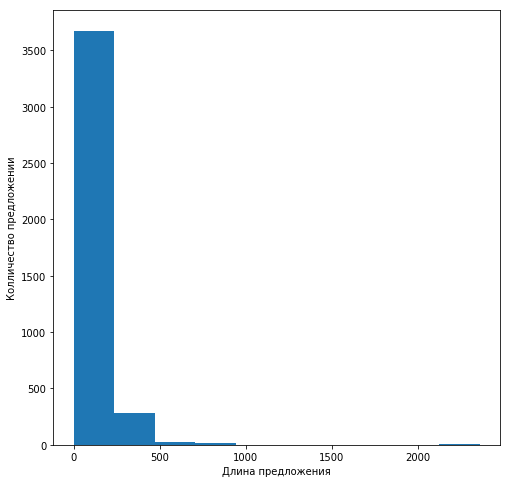

In [28]:
import matplotlib.pyplot as plt
%pylab inline
fig = plt.figure(figsize=(8, 8)) 
plt.xlabel('Длина предложения')
plt.ylabel('Колличество предложении')
plt.hist(sentence_lengths)
plt.show()

## 3. Векторизация  
<font color=darkblue>Для работы алгоритмов машинного обучения необходимо преобразовать текст в числовые признаки. Существует несколько самых частоиспользуемых методов, рассмотрим:<br/>
<font color=darkblue> - Мешок слов(BOW)<br/>
<font color=darkblue> - tf-idf<br/>
<font color=darkblue> - Word2vec<br/>


### 3.1 Мешок слов (bag of words)  

<font color=darkblue>Разделим выборку на обучающую и тестовую с помощью train_test_split. 80% данных будет в обучениющей выборке и 20 в тестовой(контрольной).

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["NormText"], df["Sentiment"], test_size=0.2,random_state=0)


<font color=darkblue>формируем мешок слов на обущающей и тестовой выборках. Получили таблицу к которой 74834 или 37621(в зависимости от норамированных текст или нет подается на вход) колонок и 3200 строк. 

In [41]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)
X_train_counts.shape

(3200, 37621)

### 4. Построим прогноз


<font color=darkblue>Применим логистическую регрессию, и вычислим показатели качества, оформим в виде процедуры для дальнейшего использования

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

def ClassificationModel(X_train, X_test, y_train, y_test):
    
    clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)

    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)
    print(classification_report(y_predicted, y_test))
    print('Accuracy',accuracy_score(y_predicted, y_test)) 
    return clf, y_predicted

c, y_pred = ClassificationModel(X_train_counts, X_test_counts, y_train, y_test)

              precision    recall  f1-score   support

        -1.0       0.89      0.89      0.89       320
         1.0       0.93      0.93      0.93       480

   micro avg       0.92      0.92      0.92       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.92      0.92      0.92       800

Accuracy 0.915


### Построим матрицу неточностей (confusion matrix)

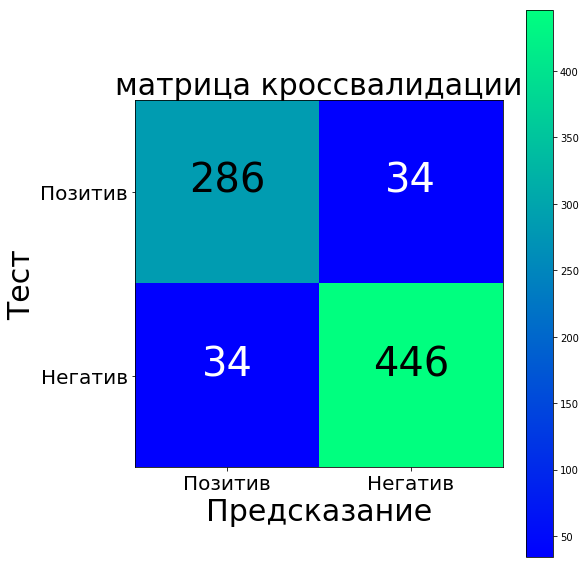

In [43]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='матрица кроссвализации',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('Тест', fontsize=30)
    plt.xlabel('Предсказание', fontsize=30)

    plt.show()

cm = confusion_matrix(y_test, y_pred)
plot = plot_confusion_matrix(cm, classes=['Позитив','Негатив'], normalize=False, title='матрица кроссвалидации')
   

### Создадим процедуру выявления самых важных слов для позитивного и негативного контекста 
<font color=darkblue>Данную процедуру можно сделать на основании анализа коээфициентов модели (coef_ при каждом слове), но т.к. они не будут показательны в случае doc2vec и word2vec, то для универсальности мы проанализируем вероятность позитивного или негативного контекста, если будем передавать для слово на вход модели. Ограничим вывод 10-ю словами для позитивного класса и 10 для негативного. <br/>
И отобразим на гистограмме:</font>

In [44]:
from functions import plot_important_words

<font color=darkblue>Подготовим процедуру с векторизации предложений:
BagOfWords, TD-IDF, Doc2Vec, n-грамм


In [45]:
from functions import split_vectorize

vectorizer, X_train, X_test, y_train, y_test = split_vectorize(df["NormText"], df["Sentiment"], 'bow')

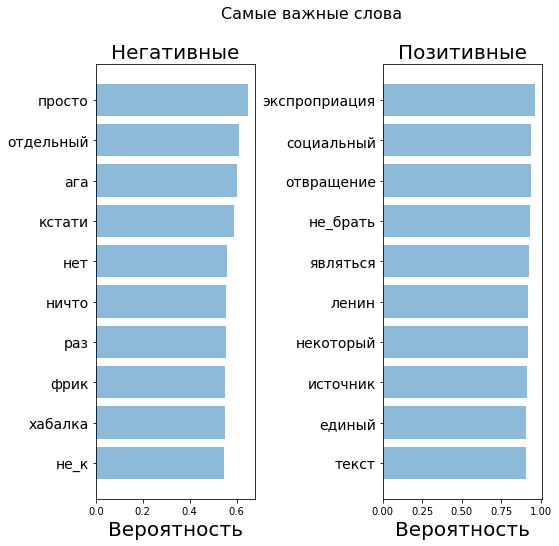

In [46]:
plot_important_words(vectorizer, c, df["NormText"])

## Теперь все готово для проверок 
<font color=darkblue>можно пробовать:<br/>
- исходные данные или нормированные;!!! можно заменить NormText на Text<br/>
- разные способы векторизации (doc2vec,bow,tfidf,ngramm)!!! подставляйте эти строки в процедуру ниже<br/>
Для nrgamm используется дополнительный параметр n=

и анализировать как меняются прогноз, матрица ошибок, популярные слова, а также распределение объектов в пространстве</font>


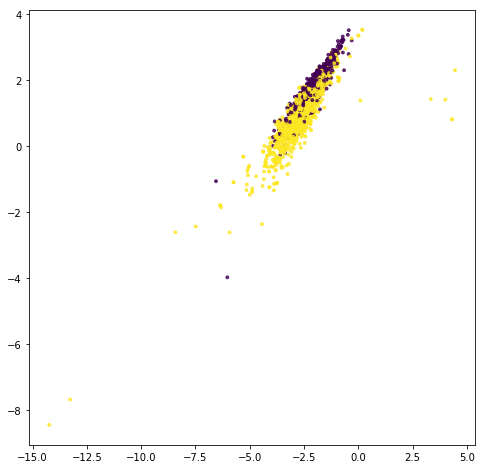

              precision    recall  f1-score   support

        -1.0       0.89      0.89      0.89       320
         1.0       0.93      0.93      0.93       480

   micro avg       0.92      0.92      0.92       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.92      0.92      0.92       800

Accuracy 0.915


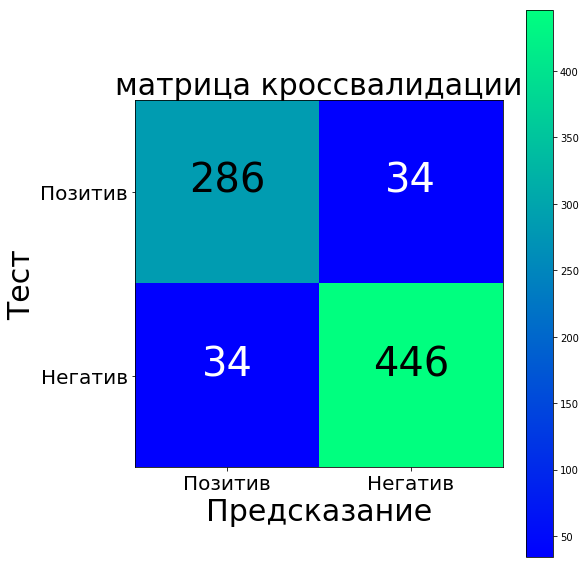

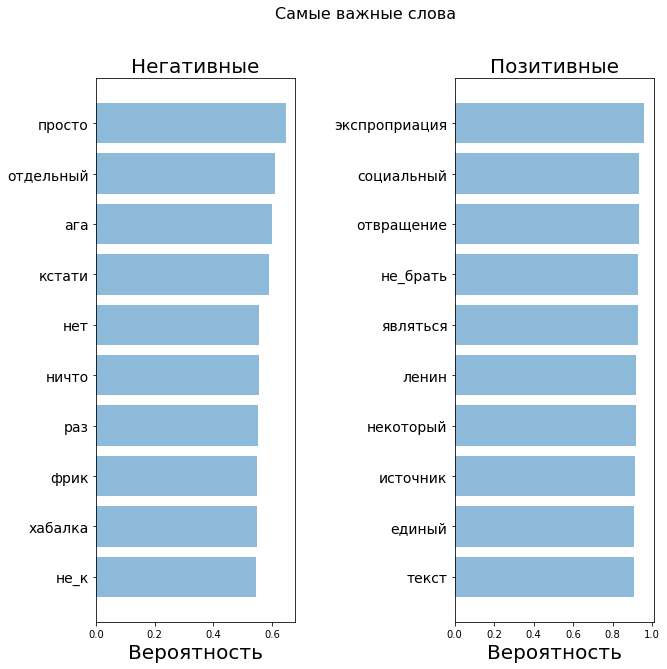

In [51]:
vectorizer, X_train, X_test, y_train, y_test = split_vectorize(df["NormText"], df["Sentiment"], method="tfidf")
lsapca_plot(X_test, y_train, ispca=False)
c, y_pred = ClassificationModel(X_train, X_test, y_train, y_test)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Позитив', 'Негатив'], normalize=False, title='матрица кроссвалидации')
plot_important_words(vectorizer, c, df["NormText"])

<font color=darkblue>попробуйте все способы векторизации и примените их для нормированного и исходного текста. обратите внимание что doc2vec в данном примере лучше работает для ненормированного текста.  

              precision    recall  f1-score   support

        -1.0       0.96      0.91      0.93       337
         1.0       0.94      0.97      0.95       463

   micro avg       0.94      0.94      0.94       800
   macro avg       0.95      0.94      0.94       800
weighted avg       0.94      0.94      0.94       800

Accuracy 0.94375


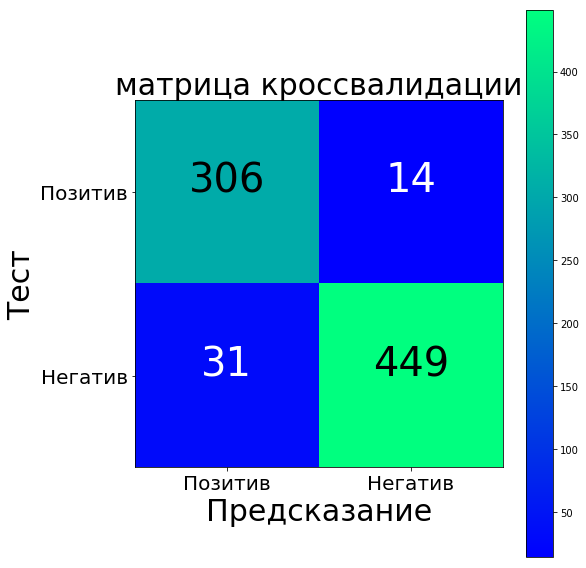

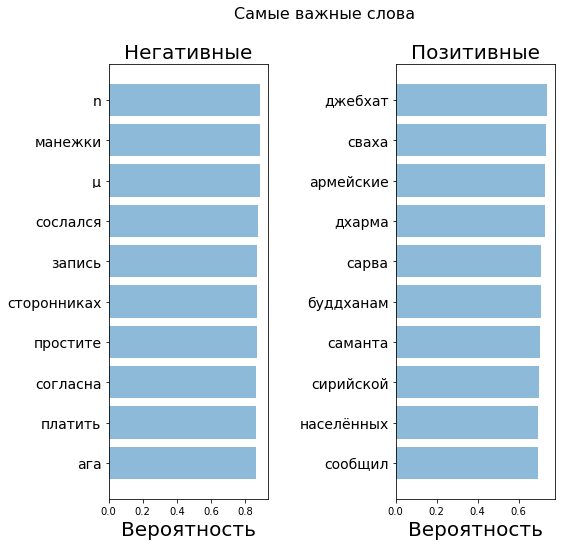

In [48]:
vectorizer, X_train, X_test, y_train, y_test = split_vectorize(df["Text"], df["Sentiment"], method="doc2vec")
c, y_pred = ClassificationModel(X_train, X_test, y_train, y_test)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Позитив', 'Негатив'], normalize=False, title='матрица кроссвалидации')
plot_important_words(vectorizer, c, df["Text"])

### Можно проверить качество классификации на тестовом примере
<font color=darkblue>обратите внимание - выборка была взята небольшая с ограниченным слованным запасом, методы начинают работать лучше при увеличении выборки<br/>
пример текста с негативным содержанием, с иронией. 

In [80]:
from functions import vectorize
vect = vectorize(vectorizer, "спасибо, я бы сам себе такое ни за что, никогда не купил")
prob = c.predict_proba(vect)
print("Классификация: ", c.predict(vect))
print("Вероятность  1:", prob[0,1])
print("Вероятность -1:", prob[0,0])

Классификация:  [-1.]
Вероятность  1: 0.36194733
Вероятность -1: 0.63805264


<font color=darkblue> положительная краткая фраза.  
    

In [87]:
from functions import vectorize
vect = vectorize(vectorizer, "обслуживание и персонал на высоте")
prob = c.predict_proba(vect)
print("Классификация: ", c.predict(vect))
print("Вероятность  1:", prob[0,1])
print("Вероятность -1:", prob[0,0])

Классификация:  [1.]
Вероятность  1: 0.70251983
Вероятность -1: 0.29748017


# Тематическое моделирование 
### ( LDA- Latent Dirichlet allocation)
<font color=darkblue>Популярная модель LDA пытается найти группы слов (темы или топики), которые часто появляются вместе. LDA также подразумевает, что каждый документ можно интерпретировать как «смесь» из нескольких тем. 
    Попробуем сгруппировать наш текст по 10 темам

In [88]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features=10000, max_df=0.15)
X = vect.fit_transform(df["NormText"])

In [89]:
from sklearn.decomposition import LatentDirichletAllocation
lda10 = LatentDirichletAllocation(n_components=10, learning_method="batch", max_iter=25, random_state=0)
document_topics10 = lda10.fit_transform(X)

In [90]:
# Для каждой темы (строки в components_) сортируем признаки (по возрастанию).
# Инвертируем строки с помощью [:, ::-1], чтобы получить сортировку по убыванию 
sorting10 = np.argsort(lda10.components_, axis=1)[:, ::-1]

# Получаем имена признаков из векторизатора.
feature_names = np.array(vect.get_feature_names())

<font color=darkblue>Отобразим ключевые 10 слов для каждой из 10 тем, для этого создадим процедуру отображения ключевыз слов для каждой темы

In [109]:
def print_topics(topics, feature_names, sorting, topics_per_chunk=6,
                 n_words=5):
        
    max_feature_name_len = max([len(name) for name in np.ravel(feature_names[sorting[topics, :n_words]])])
    
    for i in range(0, len(topics), topics_per_chunk):
        these_topics = topics[i: i + topics_per_chunk]
        len_this_chunk = len(these_topics)

        print("".join([" Тема {0:<{1}}".format(topic, max_feature_name_len - 5) for topic in these_topics]))
        print("-------- {0:<{1}}".format("", max_feature_name_len - 8) * len_this_chunk)
        for i in range(n_words):
            try:                
                print("".join(["{0:<{1}}".format(word, max_feature_name_len + 1) for word in feature_names[sorting[these_topics, i]]]))
            except:
                pass
        print("\n")

In [110]:
print_topics(topics=range(10), feature_names=feature_names, 
                           sorting=sorting10, topics_per_chunk=10, n_words=10)

 Тема 0      Тема 1      Тема 2      Тема 3      Тема 4      Тема 5      Тема 6      Тема 7      Тема 8      Тема 9     
--------    --------    --------    --------    --------    --------    --------    --------    --------    --------    
компания    просто      боязнь      мантра      русский     рубль       удача       аль         ум          область     
российский  хороший     мантра      нама        война       сша         даровать    боевик      состояние   запись      
работа      ни          страх       саманта     советский   копейка     сиддх       район       природа     русский     
система     раз         дхарма      изречь      народ       сирия       жж          армия       существо    история     
дать        ребёнок     генерал     буддхан     культура    ракета      сила        город       будда       общество    
более       дело        мир         государство ссср        оружие      promfoto    уничтожить  тело        мир         
пенсия      не_быть     майор   

<font color=darkblue>По некоторым ключевым словам можно как разбились наши данные. например: религия, политики, воспитание. Как определить оптимальное количество тем. для этого используют перплексию

# Поиск оптимального количества тем 

<font color=darkblue>Посчитаем критерий качества для количества тем от 10 до 60 с шагом 5. Довольно продолжительная операция 

In [111]:
topics_numbers = range(10, 60, 5)
ldas = [LatentDirichletAllocation(n_components=i, learning_method="batch", max_iter=25, random_state=0) for i in topics_numbers]
document_topics = [lda.fit_transform(X) for lda in ldas]
perplexities = [lda.perplexity(X) for lda in ldas]


<font color=darkblue>Отобразим на графике на котором видно что максимальное значение перплексия принимает 30 для этой выборки 

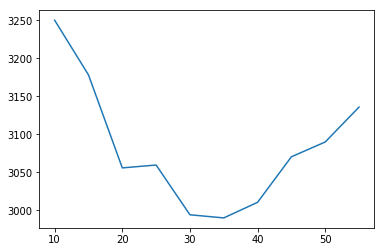

In [112]:
plt.plot(topics_numbers, perplexities)
plt.show()

<font color=darkblue> Минимум достигается при n=30, отобразим 5 ключевых слов для 20 тем, уменьшим число тем для удобства анализа. 

In [113]:
lda20 = ldas[2]
document_topics20 = document_topics[2]
sorting20 = np.argsort(lda20.components_, axis=1)[:, ::-1]
print_topics(topics=range(20), feature_names=feature_names, 
                           sorting=sorting20, topics_per_chunk=5, n_words=5)

 Тема 0       Тема 1       Тема 2       Тема 3       Тема 4      
--------     --------     --------     --------     --------     
пенсия       танк         генерал      компания     русский      
российский   армия        ракета       практика     город        
пенсионный   советский    мир          бизнес       место        
право        немецкий     комплекс     банка        цивилизация  
дать         бой          майор        начинать     стать        


 Тема 5       Тема 6       Тема 7       Тема 8       Тема 9      
--------     --------     --------     --------     --------     
рубль        жж           общество     удача        область      
копейка      promfoto     мир          даровать     наука        
стоить       мусор        жизнь        сиддх        цивилизация  
килограмм    три          человеческий сюда         научный      
цена         великий      культура     сила         учёный       


 Тема 10      Тема 11      Тема 12      Тема 13      Тема 14     
------

<font color=darkblue> проведем анализ количества документов которые попали в определенную тему. Создадим процедуру для отображения. темы озаглавим как 2 самых важных слова для каждой темы. Дополнительно отобразим количество позитивных и негативных отзывов в каждой теме.

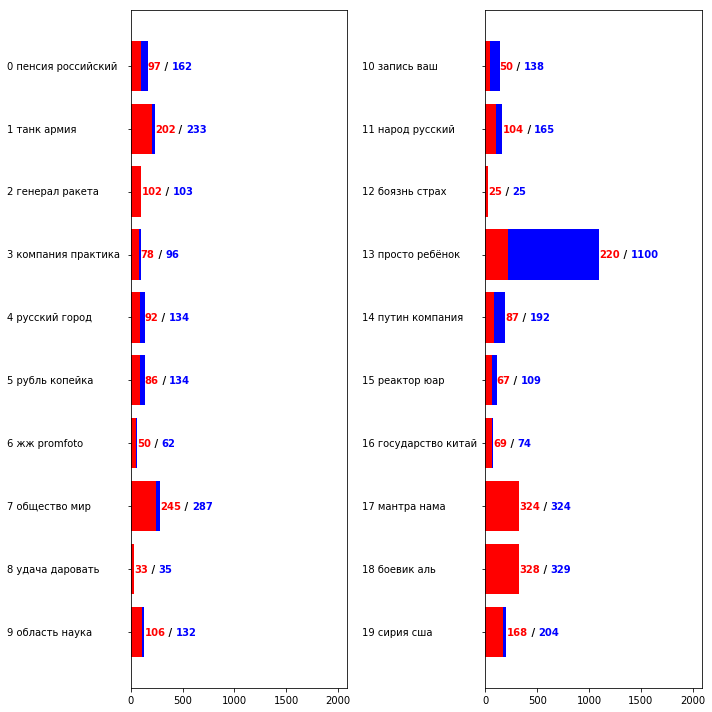

In [114]:
from matplotlib import transforms

def plotBarH(topics_number, sorting, document_topics, neg):
    value = topics_number // 2

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    topic_names = ["{0} ".format(i) + " ".join(words) for i, words in enumerate(feature_names[sorting[:, :2]])]
    topic_names_len = [len(name) for name in topic_names]
        
    scores = np.sum(document_topics, axis=0)   
    neg_scores = np.sum(document_topics * neg, axis=0)
     
    for col in [0, 1]:
        start = col * value
        end = (col + 1) * value
        col_scores = scores[start:end]
        neg_col_scores = neg_scores[start:end]

        ax[col].barh(np.arange(value), col_scores, color="blue")
        ax[col].barh(np.arange(value), neg_col_scores, color="red")
        ax[col].set_yticks(np.arange(value))
        ax[col].set_yticklabels(topic_names[start:end], ha="left", va="center")
        ax[col].invert_yaxis()
        ax[col].set_xlim(0, 1.9*max(scores))
        
        yax = ax[col].get_yaxis()
        yax.set_tick_params(pad=max(topic_names_len)*6)
        
        t_init = ax[col].transData
        canvas = ax[col].figure.canvas
        for i in range(len(col_scores)):
            score = col_scores[i]
            neg_score = neg_col_scores[i]            
            t = t_init
            
            strings = [str(round(neg_score, 2)), " / ", str(round(score, 2))]
            colors = ["red", "black", "blue"]
            for s, c in zip(strings, colors):
                text = ax[col].text(score, i, s, color=c, fontweight="bold", verticalalignment="center", 
                                    transform=t)
                text.draw(canvas.get_renderer())
                ex = text.get_window_extent()
                t = transforms.offset_copy(text.get_transform(), x=ex.width, units="dots")
            
    plt.tight_layout()
def get_document_topic(document_topics):
    max_prob = max(document_topics)
    topics = document_topics == max_prob
    return topics.astype("int32")

def get_topic_distrib(document_topics):
    doc_topics = [get_document_topic(doc) for doc in document_topics]
    return np.vstack(doc_topics)
topic_distrib20 = get_topic_distrib(document_topics20)
plotBarH(20, sorting20, topic_distrib20,np.array(df["Sentiment"] == 1).reshape((-1, 1)).astype("int32"))

<font color=darkblue> видно по каким темам больше всего данных, а также по каким темам больше позитивных или негативных отзывав в тестовой выборке. 

<font color=darkblue> Модели, получаемые с помощью LDA, представляют собой интересные методы, позволяющие интерпретировать огромные корпусы текстов, 
когда метки классов отсутствуют или когда они имеются, как в данном случае. 